In [55]:
# initialize PYNQ, overlay, xilinx drivers for the rfdc and data buffers
import pynq
from pynq import (Overlay, Xlnk, MMIO)
import xrfclk
import xrfdc

import numpy as np
from numpy import (dtype, int8, int16, float32, complex64)
from numpy import (arange, log10, abs, angle, fft)
import matplotlib.pyplot as plt

OVERLAY_PATH = '/home/xilinx/jupyter_notebooks/alpaca/overlay/rfdc_tlast/rfdc_snapshot.bit'
overlay = Overlay(OVERLAY_PATH)

# configure rfdc by programming LMX PLL to enable digitization
rfdc = overlay.usp_rf_data_converter_0

xrfclk.set_all_ref_clks(409.6)

adc_tile = rfdc.adc_tiles[0]
adc_block = adc_tile.blocks[0]

# configure dma engine
dma = overlay.axi_dma_0

xlnk = Xlnk()

# number of I/Q samples to DMA to PS
samples = 1024
words_per_pkt = 2
out_buffer = xlnk.cma_array(shape=(samples*words_per_pkt,), dtype=int16, cacheable=1)

def dma_read():
    snapshot_ip.write(0x00,1)
    dma.recvchannel.transfer(out_buffer)
    dma.recvchannel.wait()
    snapshot_ip.write(0x00,0)

# configure snapshot block
# Note that the design will hang and become unresponsive if trying to
# start the snapshot block (writing to anything on this slave) prior to
# the RFDC running (in this case setting the clock starting digitizing)
snapshot_ip = MMIO(0xA0010000, 0x10000)
snapshot_ip.write(0x10, samples)

In [56]:
# example to adjust rfdc and mixer configuration in real-time

adc_block.NyquistZone = 1
adc_block.MixerSettings = {
    'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
    'EventSource':    xrfdc.EVNT_SRC_TILE,
    'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
    'Freq':           -512.0, # a negative NCO is a shift up
    'MixerMode':      xrfdc.MIXER_MODE_R2C,
    'MixerType':      xrfdc.MIXER_TYPE_FINE,
    'PhaseOffset':    0.0
}
adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

print(adc_block.MixerSettings)

{'CoarseMixFreq': 0, 'EventSource': 2, 'FineMixerScale': 1, 'Freq': -512.0, 'MixerMode': 3, 'MixerType': 2, 'PhaseOffset': 0.0}


In [122]:
# capture a snapshot and breakout IQ samples
dma_read()

x = out_buffer.reshape(samples,2)

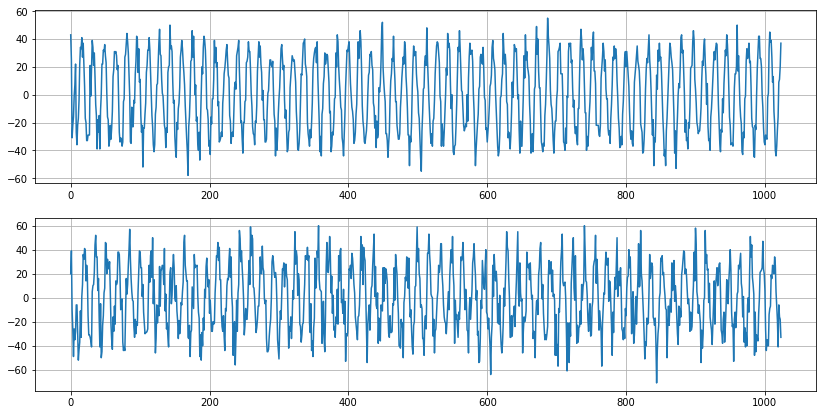

In [125]:
# plot IQ time-series
plt.rcParams["figure.figsize"] = (14,7) # set figure size (needs to be ran twice to take effect)
fig, ax = plt.subplots(2,1, sharey='row')
for i in range(0,2):
    cur_ax = ax[i]
    cur_ax.plot(arange(0,samples), x[:,i])
    cur_ax.grid(True)
plt.show()

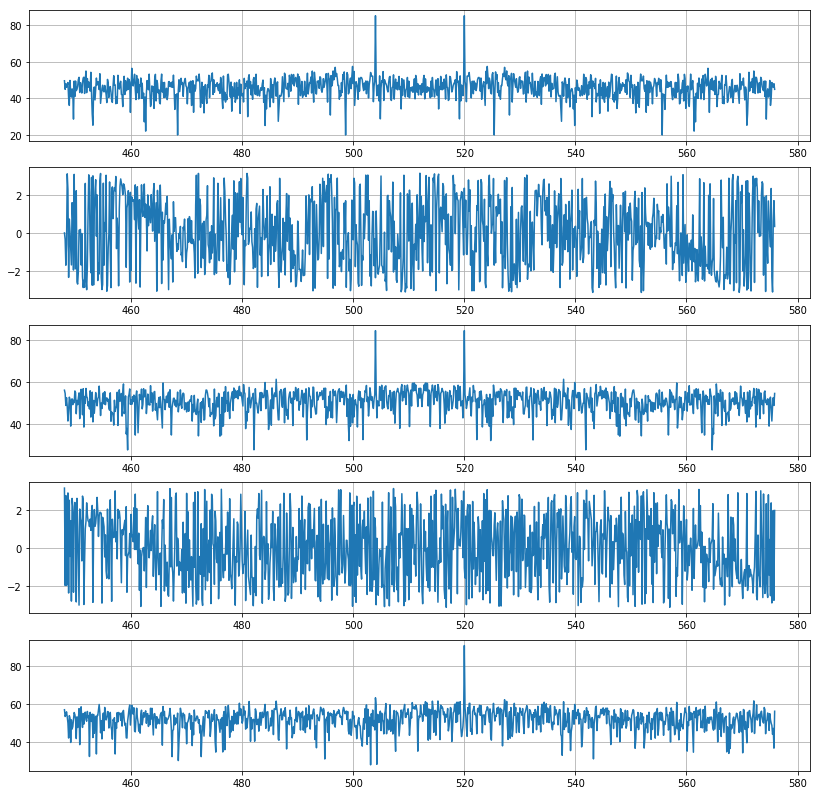

In [130]:
plt.rcParams["figure.figsize"] = (14,14) # set figure size (needs to be ran twice to take effect)

# combine I and Q to form complex basebanded lowpass equivalent signal and compute spectrum
xl = x[:,0] + 1j*x[:,1]

fs = 2048 # MHz
f_nco = 512.0
dec_factor = adc_block.DecimationFactor
f_baseband = fs/2.0/dec_factor
f_min = f_nco-(f_baseband/2.0)
f_max = f_nco+(f_baseband/2.0)

df = f_baseband/samples
faxis = np.arange(-samples/2.0, samples/2.0) * df + f_nco

X = fft.fft(xl, samples)
X_i = fft.fft(x[:,0], samples)
X_q = fft.fft(x[:,1], samples)

fig, ax = plt.subplots(5,1)
# I magnitude and phase
ax[0].plot(faxis, 20*log10(abs(fft.fftshift(X_i)))); ax[0].grid(True)
ax[1].plot(faxis, angle(X_i)); ax[1].grid(True)
# Q magnitude and phase
ax[2].plot(faxis, 20*log10(abs(fft.fftshift(X_q)))); ax[2].grid(True)
ax[3].plot(faxis, angle(X_q)); ax[3].grid(True)
# lowpass equivalent sepcturm
ax[4].plot(faxis, 20*log10(abs(fft.fftshift(X)))); ax[4].grid(True)
plt.show()